In [3]:
!pip3 install sentence-transformers matplotlib numpy torch tqdm pandas

  Using cached sentence_transformers-3.0.1-py3-none-any.whl.metadata (10 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.1 MB/s eta 0:00:00
  Using cached torch-2.3.1-cp310-cp310-manylinux1_x86_64.whl.metadata (26 kB)
  Using cached numpy-2.0.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (60 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 2.6 MB/s eta 0:00:00
  Using cached requests-2.32.3-py3-none-any.whl.metadata (4.6 kB)
  Using cached networkx-3.3-py3-none-any.whl.metadata (5.1 kB)
  Using cached jinja2-3.1.4-py3-none-any.whl.metadata (2.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached 

In [100]:
import json
from random import Random
from sentence_transformers import SentenceTransformer
import torch
from typing import List, Tuple
import itertools
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import pickle

In [2]:
with open('../cache/updated_docstrings_0.json', 'r') as f:
    updated_docstrings_0 = json.load(f)

updated_docstrings_0 = {
    mid: [list(x) for x in zip(*data)]
    for mid, data in updated_docstrings_0.items()
}

In [3]:
seed = 42
sample_size=512

with open("test_data.json", 'r') as f:
    test_data = Random(seed).sample(
        [
            {'c': item['c'], 'd': item['d'], 'l': item['l']}
            for item in json.load(f)
        ],
        k=sample_size
    )

In [15]:
eval_data = {
    mid: [td | {'g': gd} for td, gd in zip(test_data, updated_docstrings_0[mid])]
    for mid in updated_docstrings_0.keys()
}
eval_data

{'checkpoints/finetuned_0': [{'c': '    def __init__(self, file_path: str) -> None:\n        try:\n            from pdfminer.high_level import extract_text\n        except ImportError:\n            raise ImportError(\n                "`pdfminer` package not found, please install it with "\n                "`pip install pdfminer.six`"\n            )\n\n        super().__init__(file_path)\n        self.parser = PDFMinerParser()',
   'd': 'Initialize with file path.',
   'l': True,
   'g': ['.',
    '.',
    '_iter_raw_references() -> Generator[ObjectReferencePart, None, None]:\n    _iter_reference_parts(self) -> Generator[ObjectReferencePart, None, None]:\n    _iter_reference_parts(self, include_self=False) -> Generator[ObjectReferencePart, None, None]:\n    _iter_reference_parts(self, include_self=True) -> Generator[ObjectReferencePart, None, None]:\n    _iter_reference_parts(self, include_self=False, include_self_as_identifier=False) -> Generator[ObjectReferencePart, None, None]:\n    

In [5]:
model = SentenceTransformer('microsoft/codebert-base', device='cuda:0')

def perform_test(
    codes: List[str], docstrings: List[str], generated_docstrings: List[List[str]],
    distance_function: str, normalize: bool, sample_many: bool
) -> List[float]:
    assert len(codes) == len(docstrings) == len(generated_docstrings)

    n_codes = len(codes)
    n_samples = 4 if sample_many else 1

    codes = [code for code in codes for _ in range(n_samples)]
    docstrings = [docstring for docstring in docstrings for _ in range(n_samples)]
    if sample_many:
        generated_docstrings = [d for ds in generated_docstrings for d in ds]
    else:
        generated_docstrings = [d[0] for d in generated_docstrings]

    assert len(codes) == len(docstrings) == len(generated_docstrings)

    code_embeddings = model.encode(codes, normalize_embeddings=normalize)
    docstring_embeddings = model.encode(docstrings, normalize_embeddings=normalize)
    generated_docstring_embeddings = model.encode(generated_docstrings, normalize_embeddings=normalize)

    model.similarity_fn_name = distance_function

    docstring_similarities = model.similarity_pairwise(code_embeddings, docstring_embeddings)
    generated_docstring_similarities = model.similarity_pairwise(code_embeddings, generated_docstring_embeddings)

    if distance_function == 'euclidean':
        docstring_similarities = -docstring_similarities
        generated_docstring_similarities = -generated_docstring_similarities

    if sample_many:
        docstring_similarities = docstring_similarities.reshape(n_codes, n_samples)
        docstring_similarities = torch.median(docstring_similarities, dim=1).values

        generated_docstring_similarities = generated_docstring_similarities.reshape(n_codes, n_samples)
        generated_docstring_similarities = torch.median(generated_docstring_similarities, dim=1).values

    ratios = torch.div(docstring_similarities, generated_docstring_similarities)
    return ratios.tolist()


No sentence-transformers model found with name microsoft/codebert-base. Creating a new one with mean pooling.


In [6]:
ratio_results = {}

for mid, data in eval_data.items():
    codes = [d['c'] for d in data]
    docstrings = [d['d'] for d in data]
    generated_docstrings = [d['g'] for d in data]
    labels = [d['l'] for d in data]

    ratio_results[mid] = {}

    for distance_function, normalize, sample_many in tqdm(itertools.product(
        ['cosine', 'euclidean'],
        [True, False],
        [True, False]
    ), total=2*2*2):
        ratios = perform_test(codes, docstrings, generated_docstrings, distance_function, normalize, sample_many)
        ratio_results[mid][(distance_function, normalize, sample_many)] = ratios
        

100%|██████████| 8/8 [34:32<00:00, 259.02s/it]  


In [102]:
ratio_results

{'checkpoints/finetuned_0': {('cosine', True, True): [1.215024709701538,
   1.1801878213882446,
   1.5343092679977417,
   0.9335689544677734,
   1.3937071561813354,
   0.9440323710441589,
   1.2586134672164917,
   1.456436038017273,
   0.9222041964530945,
   1.7389726638793945,
   1.6034759283065796,
   1.3851253986358643,
   1.064948558807373,
   0.9437777400016785,
   1.535832405090332,
   0.9963194727897644,
   1.5824706554412842,
   1.024376392364502,
   0.9975019693374634,
   1.5580897331237793,
   0.9825649261474609,
   1.0361788272857666,
   0.975216805934906,
   1.615065097808838,
   1.5632058382034302,
   1.5235546827316284,
   1.2201893329620361,
   1.0456717014312744,
   0.9650365710258484,
   0.9124303460121155,
   1.270965814590454,
   1.0830395221710205,
   1.3693957328796387,
   1.6603580713272095,
   1.536556601524353,
   1.25315523147583,
   1.6403770446777344,
   1.399306297302246,
   0.9636114835739136,
   0.9664019346237183,
   1.7461392879486084,
   1.0109235048294

In [113]:
path = "ratio_results.pkl"
if not os.path.exists(path):
    with open(path, 'wb') as f:
        pickle.dump(ratio_results, f)
else:
    with open(path, 'rb') as f:
        ratio_results = pickle.load(f)

In [114]:
print(len(ratio_results['checkpoints/finetuned_0']))
print(len(ratio_results['google/codegemma-2b']))

ratio_results['checkpoints/finetuned_0']

8
8


{('cosine', True, True): [1.215024709701538,
  1.1801878213882446,
  1.5343092679977417,
  0.9335689544677734,
  1.3937071561813354,
  0.9440323710441589,
  1.2586134672164917,
  1.456436038017273,
  0.9222041964530945,
  1.7389726638793945,
  1.6034759283065796,
  1.3851253986358643,
  1.064948558807373,
  0.9437777400016785,
  1.535832405090332,
  0.9963194727897644,
  1.5824706554412842,
  1.024376392364502,
  0.9975019693374634,
  1.5580897331237793,
  0.9825649261474609,
  1.0361788272857666,
  0.975216805934906,
  1.615065097808838,
  1.5632058382034302,
  1.5235546827316284,
  1.2201893329620361,
  1.0456717014312744,
  0.9650365710258484,
  0.9124303460121155,
  1.270965814590454,
  1.0830395221710205,
  1.3693957328796387,
  1.6603580713272095,
  1.536556601524353,
  1.25315523147583,
  1.6403770446777344,
  1.399306297302246,
  0.9636114835739136,
  0.9664019346237183,
  1.7461392879486084,
  1.0109235048294067,
  1.0111559629440308,
  1.0289230346679688,
  1.033232569694519,

In [115]:
def matthews_correlation(tp: int, tn: int, fp: int, fn: int) -> float:
    numerator = tp * tn - fp * fn
    denominator = ((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)) ** 0.5
    return numerator / denominator

def p4_score(tp: int, tn: int, fp: int, fn: int) -> float:
    return (4 * tp * tn) / (4 * tp * tn + (tp + tn) * (fp + fn))

In [121]:
search_results = {}

for distance_function, normalize, sample_many in tqdm(itertools.product(
    ['cosine', 'euclidean'],
    [True, False],
    [True, False]
), total=2*2*2):
    for mid in eval_data.keys():
        ratios = ratio_results[mid][(distance_function, normalize, sample_many)]
        labels = [d['l'] for d in eval_data[mid]]
        p4s = []
        thresholds = []
        confusion_matrices = []

        for threshold in np.linspace(0, 3, 200):
            classifications = [r <= threshold for r in ratios]
            tp = sum(
                (1 if (l and c) else 0) 
                for l, c in zip(labels, classifications)
            )
            tn = sum(
                (1 if (not l and not c) else 0) 
                for l, c in zip(labels, classifications)
            )
            fp = sum(
                (1 if (not l and c) else 0) 
                for l, c in zip(labels, classifications)
            )
            fn = sum(
                (1 if (l and not c) else 0) 
                for l, c in zip(labels, classifications)
            )
            p4 = p4_score(tp, tn, fp, fn)
            p4s.append(p4)
            thresholds.append(threshold)
            confusion_matrices.append((tp, tn, fp, fn))

        search_results[(mid, distance_function, normalize, sample_many)] = (
            thresholds, p4s, confusion_matrices
        )


100%|██████████| 8/8 [00:00<00:00, 24.54it/s]


In [123]:
df = pd.DataFrame(columns=[
    'mid', 'distance_function', 'normalize', 'sample_many', 'test_threshold', 'p4',
    'tp', 'tn', 'fp', 'fn'
])

for mid, distance_function, normalize, sample_many in tqdm(itertools.product(
    ['checkpoints/finetuned_0', 'google/codegemma-2b'],
    ['cosine', 'euclidean'],
    [True, False],
    [True, False]
), total=2*2*2):
    for threshold, p4, (tp, tn, fp, fn) in zip(*search_results[(mid, distance_function, normalize, sample_many)]):
        df.loc[len(df)] = {
            'mid': mid,
            'distance_function': distance_function,
            'normalize': normalize,
            'sample_many': sample_many,
            'test_threshold': threshold,
            'p4': p4,
            'tp': tp,
            'tn': tn,
            'fp': fp,
            'fn': fn
        }

df

  0%|          | 0/8 [00:00<?, ?it/s]

16it [00:01,  8.26it/s]                      


,mid,distance_function,normalize,sample_many,test_threshold,p4,tp,tn,fp,fn
0,checkpoints/finetuned_0,cosine,True,True,0.000000,0.0,0,243,0,269
1,checkpoints/finetuned_0,cosine,True,True,0.015075,0.0,0,243,0,269
2,checkpoints/finetuned_0,cosine,True,True,0.030151,0.0,0,243,0,269
3,checkpoints/finetuned_0,cosine,True,True,0.045226,0.0,0,243,0,269
4,checkpoints/finetuned_0,cosine,True,True,0.060302,0.0,0,243,0,269
...,...,...,...,...,...,...,...,...,...,...
3195,google/codegemma-2b,euclidean,False,False,2.939698,0.0,269,0,243,0
3196,google/codegemma-2b,euclidean,False,False,2.954774,0.0,269,0,243,0
3197,google/codegemma-2b,euclidean,False,False,2.969849,0.0,269,0,243,0
3198,google/codegemma-2b,euclidean,False,False,2.984925,0.0,269,0,243,0


In [124]:
optimum_df = df.nlargest(1, 'p4')
X_opt = optimum_df['test_threshold'].values[0]
Y_opt = optimum_df['p4'].values[0]

print(X_opt, Y_opt)

1.3869346733668342 0.5335448285806986


In [125]:
df_opt = df.groupby(['mid', 'distance_function', 'normalize', 'sample_many']).apply(lambda x: x.nlargest(1, 'p4')).reset_index(drop=True)
df_opt


/tmp/ipykernel_362504/4082372899.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_opt = df.groupby(['mid', 'distance_function', 'normalize', 'sample_many']).apply(lambda x: x.nlargest(1, 'p4')).reset_index(drop=True)


,mid,distance_function,normalize,sample_many,test_threshold,p4,tp,tn,fp,fn
0,checkpoints/finetuned_0,cosine,False,False,1.341709,0.509823,186,91,152,83
1,checkpoints/finetuned_0,cosine,False,True,1.386935,0.533545,185,100,143,84
2,checkpoints/finetuned_0,cosine,True,False,1.341709,0.509823,186,91,152,83
3,checkpoints/finetuned_0,cosine,True,True,1.386935,0.533545,185,100,143,84
4,checkpoints/finetuned_0,euclidean,False,False,0.889447,0.504510,139,120,123,130
5,checkpoints/finetuned_0,euclidean,False,True,0.904523,0.530913,131,141,102,138
6,checkpoints/finetuned_0,euclidean,True,False,0.874372,0.502399,139,119,124,130
7,checkpoints/finetuned_0,euclidean,True,True,0.783920,0.530355,115,160,83,154
8,google/codegemma-2b,cosine,False,False,1.010050,0.491935,130,122,121,139
9,google/codegemma-2b,cosine,False,True,1.010050,0.495100,119,135,108,150


/tmp/ipykernel_362504/733005911.py:45: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(X_best, Y_best, c=color, marker=marker, s=200, label=label)


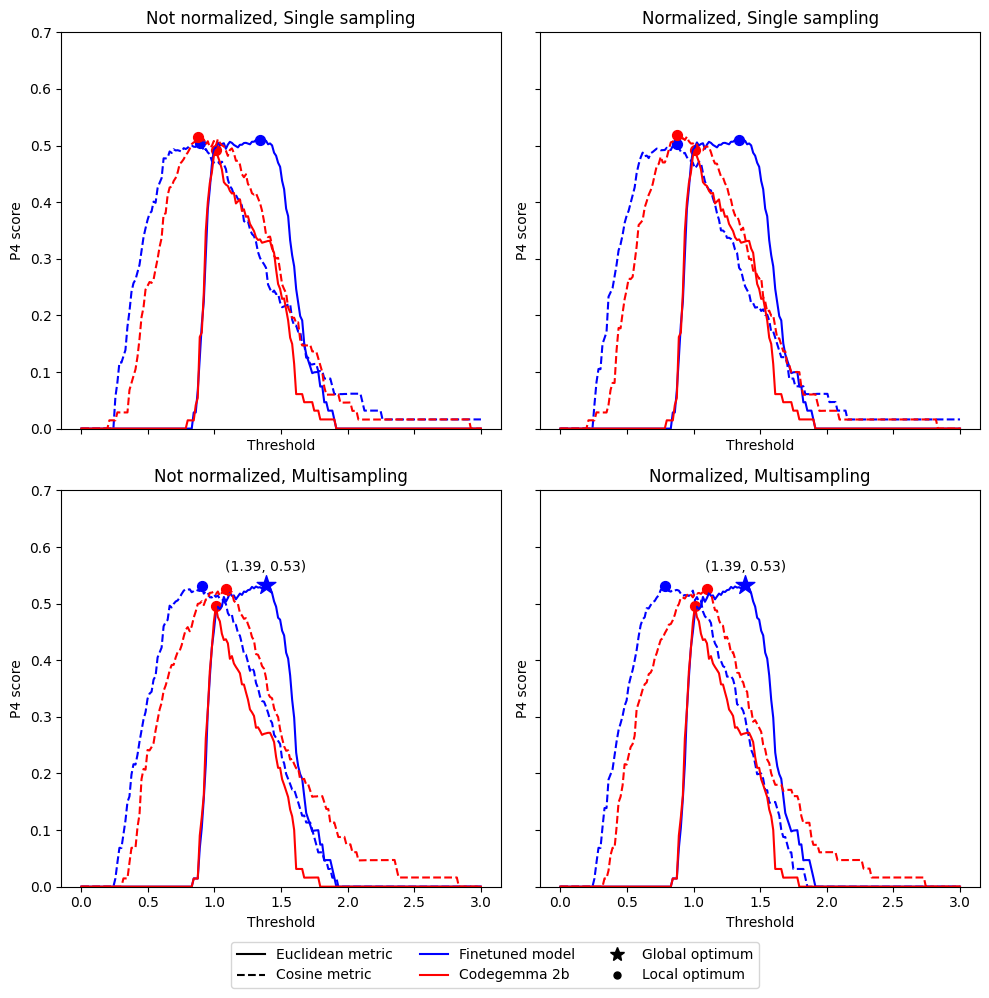

In [96]:
mids = ['checkpoints/finetuned_0', 'google/codegemma-2b']
distance_functions = ['cosine', 'euclidean']
normalize_values = [False, True]
sample_many_values = [False, True]

fig, axs = plt.subplots(2, 2, figsize=(10, 10), sharey=True, sharex=True)
colors = [plt.get_cmap('bwr')(i) for i in (0, 1 - 1e-6)]
line_styles = ['-', '--']

for y, normalize in enumerate(normalize_values):
    for x, sample_many in enumerate(sample_many_values):
        ax = axs[x, y]
        for (color, line_style), (mid, distance_function) in zip(itertools.product(colors, line_styles), itertools.product(mids, distance_functions)):
            df_ = df[
                (df['mid'] == mid) &
                (df['distance_function'] == distance_function) &
                (df['normalize'] == normalize) &
                (df['sample_many'] == sample_many)
            ]
            X = df_['test_threshold']
            Y = df_['p4']
            if len(X) == 0 or len(Y) == 0:
                continue
            XY = list(zip(X, Y))
            XY.sort(key=lambda x: x[0])
            X, Y = zip(*XY)

            XY_best = max(XY, key=lambda x: x[1])
            X_best, Y_best = XY_best

            title = ""
            title += "Normalized, " if normalize else "Not normalized, "
            title += "Multisampling" if sample_many else "Single sampling"
            ax.set_title(title)
            
            ax.plot(X, Y, c=color, linestyle=line_style, label=f'Model: {mid}; Distance metric: {distance_function}')

            is_best = X_best == X_opt and Y_best == Y_opt

            marker = mpl.markers.MarkerStyle(
                marker='*' if is_best else '.',
                fillstyle='full'# if distance_function == 'cosine' else 'none'
            )
            label = 'Global optimum' if is_best else 'Local optimum*'
            ax.scatter(X_best, Y_best, c=color, marker=marker, s=200, label=label)
            if is_best:
                ax.annotate(f'({X_best:.2f}, {Y_best:.2f})', (X_best, Y_best), textcoords="offset points", xytext=(0, 10), ha='center')

            ax.set_xlabel('Threshold')
            ax.set_ylabel('P4 score')

            ax.set_ylim([0, 0.7])

legend_elements = [
    mpl.lines.Line2D([0], [0], color='black', linestyle='-', label='Euclidean metric'),
    mpl.lines.Line2D([0], [0], color='black', linestyle='--', label='Cosine metric'),
    mpl.lines.Line2D([0], [0], color=colors[0], label='Finetuned model'),
    mpl.lines.Line2D([0], [0], color=colors[1], label='Codegemma 2b'),
    mpl.lines.Line2D([0], [0], marker='*', color='k', label='Global optimum', markersize=10, linestyle='None'),
    mpl.lines.Line2D([0], [0], marker='.', color='k', label='Local optimum', markersize=10, linestyle='None')
]
fig.legend(handles=legend_elements, loc='lower center', ncol=3, bbox_to_anchor=(0.5, 0))
fig.tight_layout(rect=[0, 0.05, 1, 1])


In [105]:
with open('../cache/updated_docstrings_1.json', 'r') as f:
    updated_docstrings_1 = json.load(f)

updated_docstrings_1 = {
    mid: [list(x) for x in zip(*data)]
    for mid, data in updated_docstrings_1.items()
}

seed = 1337
sample_size=512

with open("test_data.json", 'r') as f:
    test_data_2 = Random(seed).sample(
        [
            {'c': item['c'], 'd': item['d'], 'l': item['l']}
            for item in json.load(f)
        ],
        k=sample_size
    )

eval_data_2 = {
    mid: [td | {'g': gd} for td, gd in zip(test_data_2, updated_docstrings_0[mid])]
    for mid in updated_docstrings_0.keys()
}


In [106]:
mid = "checkpoints/finetuned_0"

data = eval_data_2[mid]

codes = [d['c'] for d in data]
docstrings = [d['d'] for d in data]
generated_docstrings = [d['g'] for d in data]
labels = [d['l'] for d in data]

ratios_2 = perform_test(
    codes, docstrings, generated_docstrings, 
    distance_function='euclidean',
    normalize=False, 
    sample_many=True
)
       

In [126]:
path = "ratios_2.pkl"
if not os.path.exists(path):
    with open(path, 'wb') as f:
        pickle.dump(ratios_2, f)
else:
    with open(path, 'rb') as f:
        ratios_2 = pickle.load(f)

In [127]:
threshold = 1.39
labels = [d['l'] for d in eval_data_2[mid]]
classifications = [r <= threshold for r in ratios_2]
tp = sum(
    (1 if (l and c) else 0) 
    for l, c in zip(labels, classifications)
)
tn = sum(
    (1 if (not l and not c) else 0) 
    for l, c in zip(labels, classifications)
)
fp = sum(
    (1 if (not l and c) else 0) 
    for l, c in zip(labels, classifications)
)
fn = sum(
    (1 if (l and not c) else 0) 
    for l, c in zip(labels, classifications)
)
p4 = p4_score(tp, tn, fp, fn)

print(f"TP: {tp}, TN: {tn}, FP: {fp}, FN: {fn}")
print(f"P4 score: {p4}")

TP: 212, TN: 39, FP: 220, FN: 41
P4 score: 0.3354736617875293
